In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [83]:
data = pd.read_csv('retail.csv')
data.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


# Data Processing

In [84]:
missing_data = data.isnull().sum()
missing_values = any(missing_data)
if missing_values:
    print('Missing Values Found')
else:
    print('No Missing Values Found')

No Missing Values Found


In [85]:
duplicated_data = data.duplicated()
duplicated_values = duplicated_data.sum()
if duplicated_values:
    print(duplicated_values, 'Duplicate Values Found')
else:
    print('No Duplicate Values Found')

No Duplicate Values Found


In [86]:
# Steps to find outliers:
# Define a list of numerical variables to check for outliers
# Iterate through each numerical variable
# Calculate Z-score for the current numerical variable
# Set the threshold for identifying outliers (e.g., 3)
# Identify outliers using Z-score method
# Calculate IQR for the current numerical variable
# Set the thresholds for identifying outliers using IQR method
# Identify outliers using IQR method


numerical_variables = data.select_dtypes(include=['number']).columns.tolist()
for var in numerical_variables:
    z_scores = np.abs((data[var] - data[var].mean()) / data[var].std())
    z_threshold = 3

    outliers_zscore = data[z_scores > z_threshold]

    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    outliers_iqr = data[(data[var] < lower_threshold) | (data[var] > upper_threshold)]

    # Check if outliers are found using both methods for the current variable
    if not outliers_zscore.empty or not outliers_iqr.empty:
        print(f"Outliers found for '{var}' variable using Z-score method:")
        print(outliers_zscore)

        print(f"\nOutliers found for '{var}' variable using IQR method:")
        print(outliers_iqr)
    else:
        print(f"No outliers found for '{var}' variable.")

No outliers found for 'Transaction ID' variable.
No outliers found for 'Age' variable.
No outliers found for 'Quantity' variable.
No outliers found for 'Price per Unit' variable.
No outliers found for 'Total Amount' variable.


In [87]:
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

# Initialize a list to store columns requiring feature scaling
columns_to_scale = []

# Threshold for standard deviation to identify columns requiring scaling
std_threshold = 10 # Adjust as needed based on your dataset

# Iterate over numerical columns and check for scaling requirement
for col in numerical_columns:
    std_value = data[col].std()
    if std_value > std_threshold:
        columns_to_scale.append(col)

print("Columns requiring feature scaling:")
print(columns_to_scale)

Columns requiring feature scaling:
['Transaction ID', 'Age', 'Price per Unit', 'Total Amount']


In [88]:
data['Date'] = pd.to_datetime(data['Date'])
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data.drop(columns=['Date'], inplace = True)
data.head()

,Transaction ID,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Day,Month,Year
0,1,CUST001,Male,34,Beauty,3,50,150,24,11,2023
1,2,CUST002,Female,26,Clothing,2,500,1000,27,2,2023
2,3,CUST003,Male,50,Electronics,1,30,30,13,1,2023
3,4,CUST004,Male,37,Clothing,1,500,500,21,5,2023
4,5,CUST005,Male,30,Beauty,2,50,100,6,5,2023


# Data Visualization

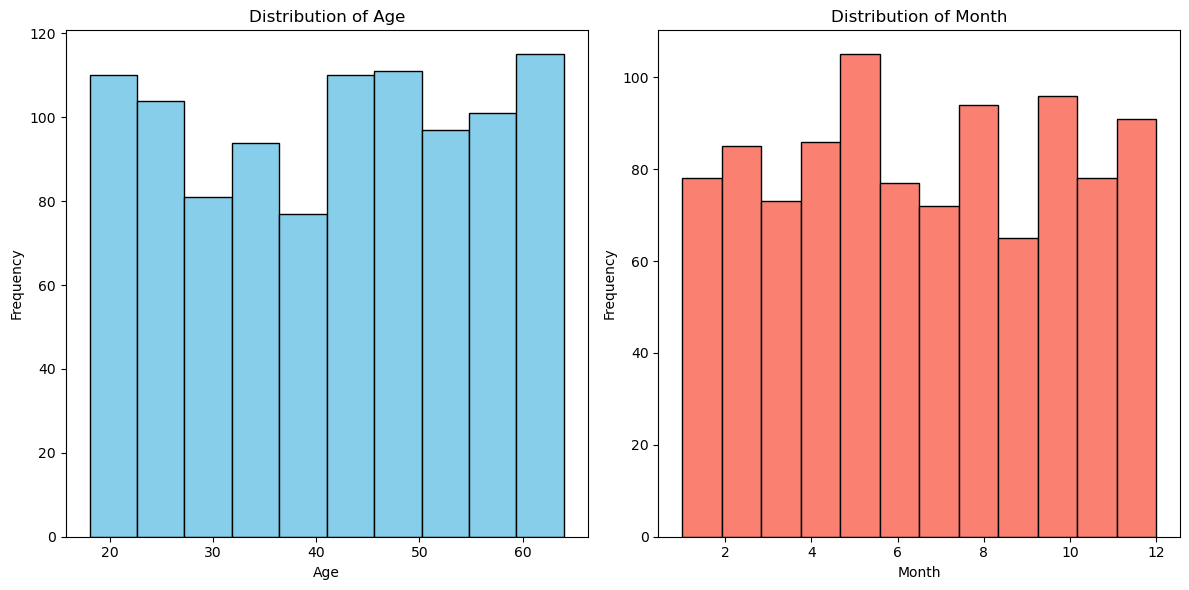

In [91]:
# Create separate histograms for 'Age' and 'Month' based on total sales
plt.figure(figsize=(12, 6))

# Histogram for 'Age'
plt.subplot(1, 2, 1)
plt.hist(data['Age'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram for 'Month'
plt.subplot(1, 2, 2)
plt.hist(data['Month'], bins=12, color='salmon', edgecolor='black')
plt.title('Distribution of Month')
plt.xlabel('Month')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

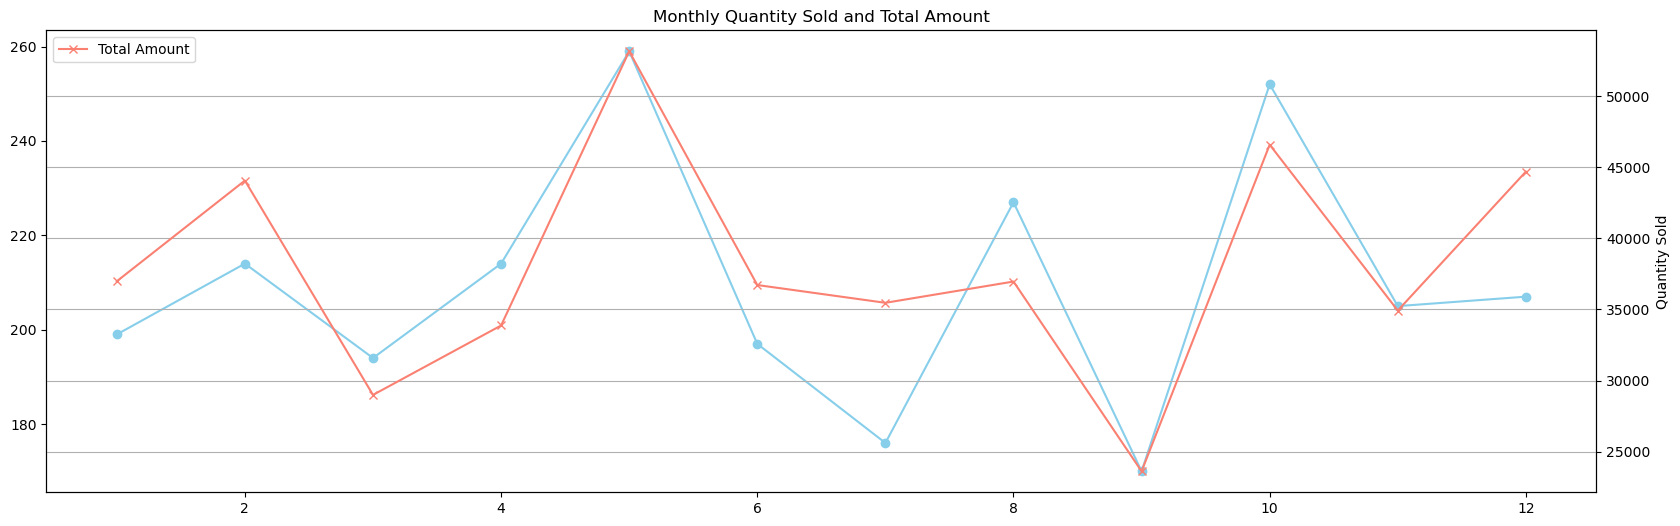

In [96]:
# Group data by 'Month' and calculate the sum of 'Quantity' and 'Total Amount'
monthly_data = data.groupby('Month').agg({'Quantity': 'sum', 'Total Amount': 'sum'}).reset_index()

# Create a line plot for 'Month' and 'Quantity' sold
plt.figure(figsize=(20, 6))
plt.plot(monthly_data['Month'], monthly_data['Quantity'], marker='o', color='skyblue', label='Quantity Sold')

# Create a second y-axis for 'Total Amount'
plt.twinx()
plt.plot(monthly_data['Month'], monthly_data['Total Amount'], marker='x', color='salmon', label='Total Amount')

# Set plot labels and title
plt.title('Monthly Quantity Sold and Total Amount')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.grid(True)

# Show legend
plt.legend(loc='upper left')

# Show plot
plt.show()

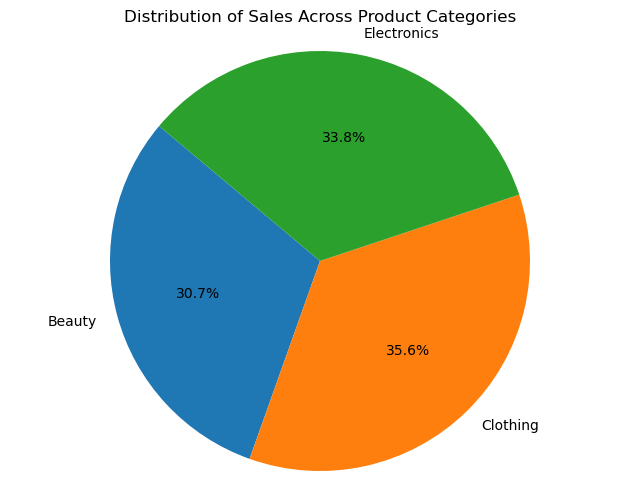

In [97]:
# Group data by 'Product Category' and calculate the sum of 'Quantity' sold for each category
category_sales = data.groupby('Product Category')['Quantity'].sum().reset_index()

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(category_sales['Quantity'], labels=category_sales['Product Category'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sales Across Product Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

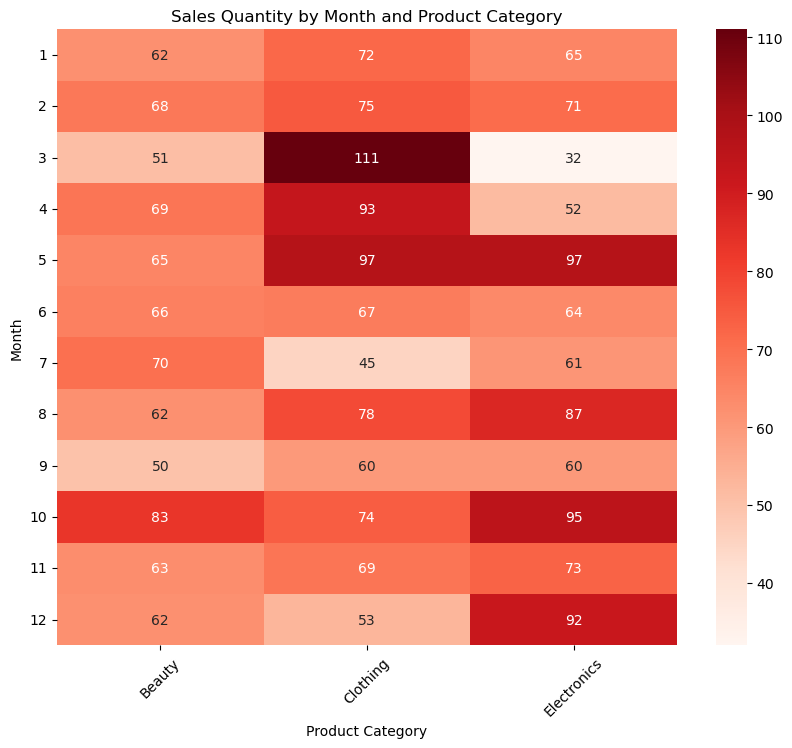

In [100]:
# Pivot the data to create a matrix where rows are months, columns are product categories, and values are quantities sold
heatmap_data = data.pivot_table(index='Month', columns='Product Category', values='Quantity', aggfunc='sum')

# Create a heatmap with red color
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title('Sales Quantity by Month and Product Category')
plt.xlabel('Product Category')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

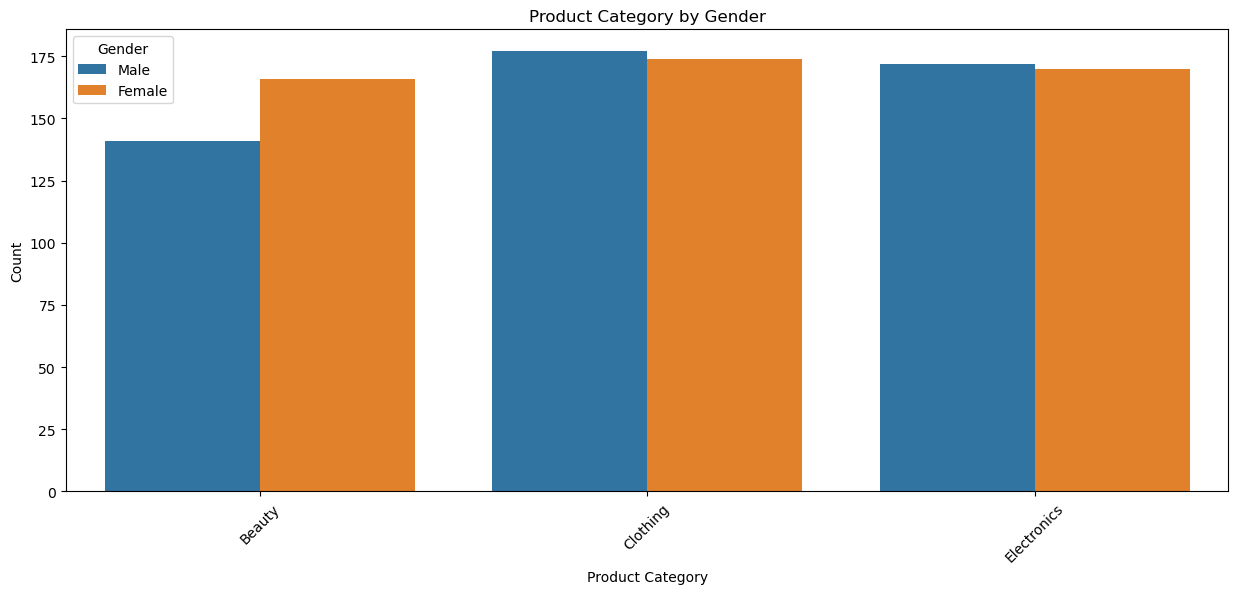

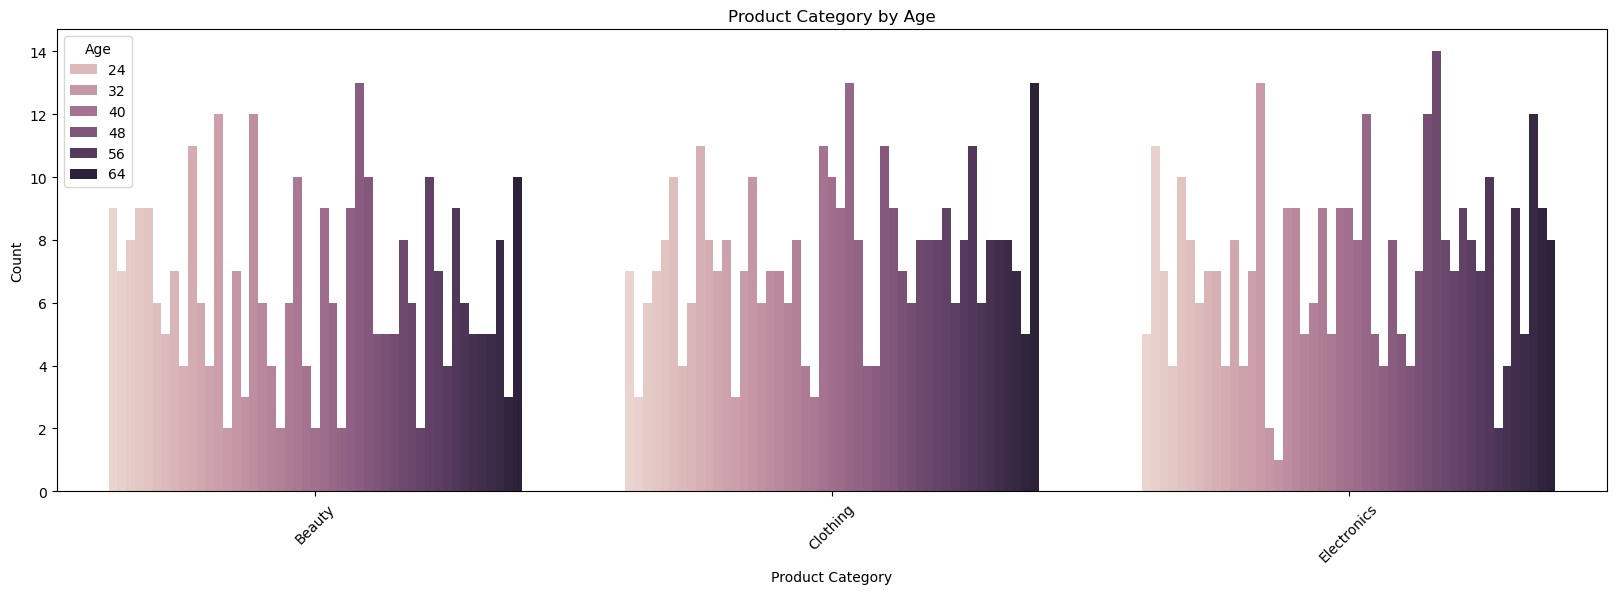

In [105]:
# Plot to understand which gender buys which product category
plt.figure(figsize=(15, 6))
sns.countplot(x='Product Category', hue='Gender', data=data)
plt.title('Product Category by Gender')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot to understand which age category buys which product
plt.figure(figsize=(20, 6))
sns.countplot(x='Product Category', hue='Age', data=data)
plt.title('Product Category by Age')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Age')
plt.show()

# Data Modeling

In [71]:
# Check for duplicate values in the 'Customer ID' column
# If there are no duplicate customer IDs, remove 'Customer ID' from features (X)

duplicate_customers = data['Customer ID'].duplicated()
if not duplicate_customers.any():
    X = data.drop(columns=['Transaction ID','Total Amount', 'Customer ID'])  # Exclude 'Total Amount' and 'Customer ID' from features
else:
    X = data.drop(columns=['Transaction ID', 'Total Amount'])  # Exclude 'Total Amount' from features

y = data['Total Amount']

In [78]:
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(X['Gender'])
X['Product Category'] = label_encoder.fit_transform(X['Product Category'])

In [80]:
X.head(10)

,Gender,Age,Product Category,Quantity,Price per Unit,Day,Month,Year
0,1,34,0,3,50,24,11,2023
1,0,26,1,2,500,27,2,2023
2,1,50,2,1,30,13,1,2023
3,1,37,1,1,500,21,5,2023
4,1,30,0,2,50,6,5,2023
5,0,45,0,1,30,25,4,2023
6,1,46,1,2,25,13,3,2023
7,1,30,2,4,25,22,2,2023
8,1,63,2,2,300,13,12,2023
9,0,52,1,4,50,7,10,2023


In [109]:
# Calculate the correlation coefficients
correlation = X.corrwith(y).sort_values(ascending=False)
print(correlation)

Price per Unit      0.851925
Quantity            0.373707
Day                 0.036889
Year                0.024714
Gender             -0.001001
Month              -0.005197
Product Category   -0.005705
Age                -0.060568
dtype: float64


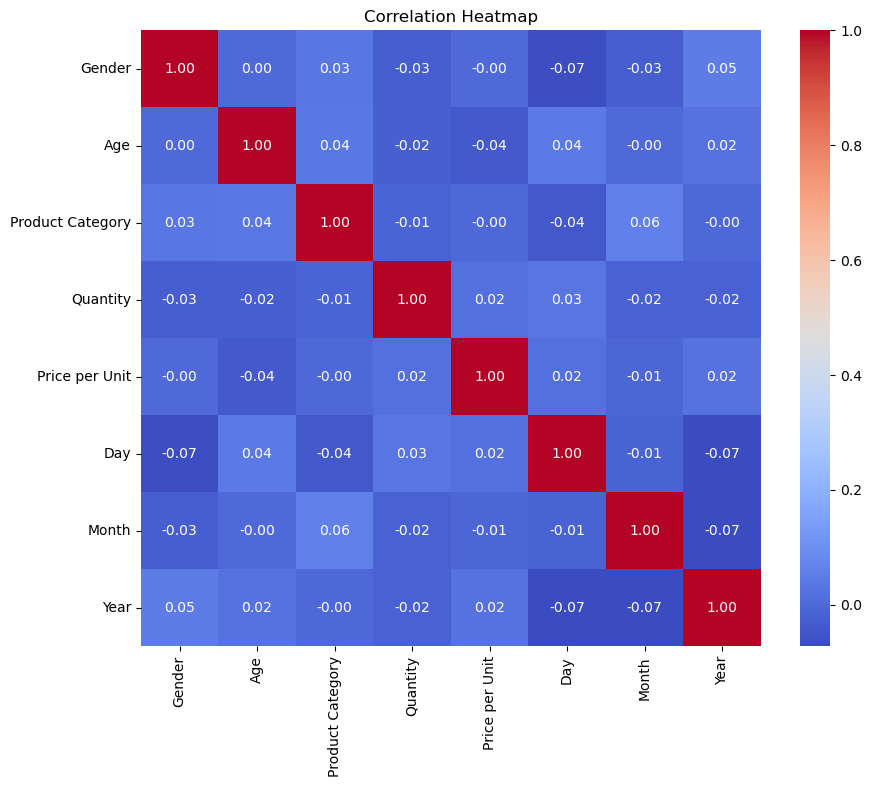

In [110]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [112]:

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (800, 8) (800,)
Testing set shape: (200, 8) (200,)


# Linear Regression

In [113]:
from sklearn.linear_model import LinearRegression
# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Print model coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: -447.48049580603856
Coefficients: [ 13.79042852  -0.93338833   1.76683881 179.49111586   2.48592238
   1.56273788   2.44133933   0.        ]


In [114]:
# Predict Total Amount using the trained model
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 42787.32106234264
R-squared (R2): 0.8538330891163948


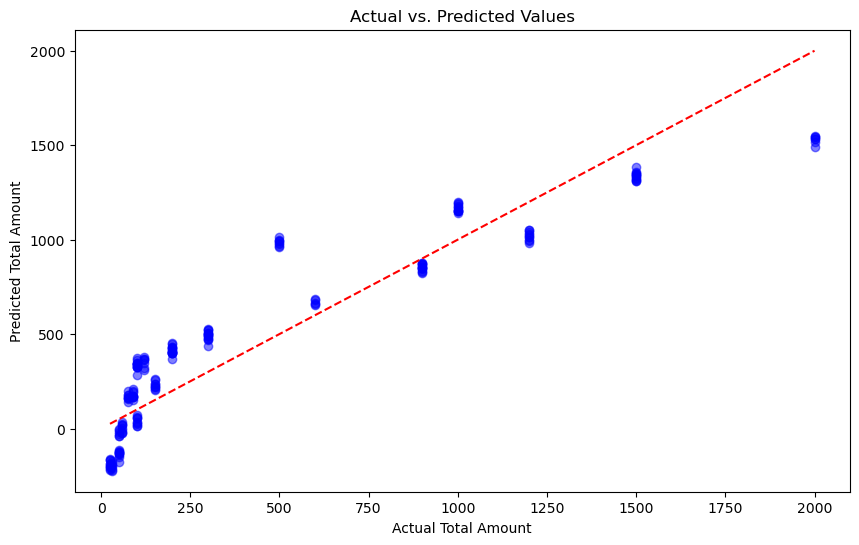

In [115]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Total Amount')
plt.ylabel('Predicted Total Amount')
plt.show()


### The Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. In this case, the MSE value of approximately 42787.32 indicates that, on average, the squared difference between the predicted Total Amount values and the actual Total Amount values is around 42787.32. Lower values of MSE indicate better model performance, so this MSE value suggests that the model's predictions are relatively close to the actual values, but there is still room for improvement.

### The R-squared (R2) score measures the proportion of the variance in the target variable (Total Amount) that is predictable from the features. The R2 score of approximately 0.8538 indicates that around 85.38% of the variance in the Total Amount can be explained by the features included in the model. Higher values of R2 indicate better model performance, so this R2 score suggests that the model is doing a good job of capturing the variation in Total Amount based on the features.

# Decision Tree

In [119]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the decision tree regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
tree_regressor.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_regressor.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("Mean Squared Error (MSE) for Decision Tree:", mse_tree)
print("R-squared (R2) Score for Decision Tree:", r2_tree)

Mean Squared Error (MSE) for Decision Tree: 0.0
R-squared (R2) Score for Decision Tree: 1.0


# Cross Validation for Decision Tree

In [120]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(tree_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive values and calculate the mean
cv_mse_scores = -cv_scores
cv_mse_mean = cv_mse_scores.mean()

# Print the cross-validation MSE scores and mean
print("Cross-Validation MSE Scores:", cv_mse_scores)
print("Mean Cross-Validation MSE:", cv_mse_mean)

Cross-Validation MSE Scores: [0. 0. 0. 0. 0.]
Mean Cross-Validation MSE: 0.0


# Cross Validation for Random Forest

In [121]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor()

# Perform cross-validation
cv_scores_rf = cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive values and calculate the mean
cv_mse_scores_rf = -cv_scores_rf
cv_mse_mean_rf = cv_mse_scores_rf.mean()

# Print the cross-validation MSE scores and mean
print("Cross-Validation MSE Scores for Random Forest:", cv_mse_scores_rf)
print("Mean Cross-Validation MSE for Random Forest:", cv_mse_mean_rf)

Cross-Validation MSE Scores for Random Forest: [0. 0. 0. 0. 0.]
Mean Cross-Validation MSE for Random Forest: 0.0


# Cross Validation for SVM

In [122]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Create an SVM regressor
svm_regressor = SVR()

# Perform cross-validation
cv_scores_svm = cross_val_score(svm_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive values and calculate the mean
cv_mse_scores_svm = -cv_scores_svm
cv_mse_mean_svm = cv_mse_scores_svm.mean()

# Print the cross-validation MSE scores and mean
print("Cross-Validation MSE Scores for SVM:", cv_mse_scores_svm)
print("Mean Cross-Validation MSE for SVM:", cv_mse_mean_svm)


Cross-Validation MSE Scores for SVM: [504238.2388611  322235.61331574 509819.5055423  395543.69947
 262783.34525734]
Mean Cross-Validation MSE for SVM: 398924.08048929635
